# 1. Формулировка бизнес-задачи и выбор подхода машинного обучения

**Бизнес-задача:** предсказание кредитоспособности клиентов для банка, с целью минимизации рисков предоставления кредитов ненадежным заемщикам и улучшения клиентской базы.

**Задача машинного обучения**: Бинарная классификация (определение кредитоспособности клиента).

Для решения задачи был использован датасет с сайта openml.org, содержащий различные характеристики клиентов, такие как:
- Проверка статуса счета
- Продолжительность кредита
- История кредита
- Цель кредита
- Сумма кредита и др.

ID датасета: 31


# Загрузка датасета

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dataset = fetch_openml(data_id=31, as_frame=True)

df = dataset.frame

print(df.head())
print(df.info())

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


  checking_status  duration                  credit_history  \
0              <0       6.0  critical/other existing credit   
1        0<=X<200      48.0                   existing paid   
2     no checking      12.0  critical/other existing credit   
3              <0      42.0                   existing paid   
4              <0      24.0              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv         1169.0  no known savings        >=7   
1             radio/tv         5951.0              <100     1<=X<4   
2            education         2096.0              <100     4<=X<7   
3  furniture/equipment         7882.0              <100     4<=X<7   
4              new car         4870.0              <100     1<=X<4   

   installment_commitment     personal_status other_parties  ...  \
0                     4.0         male single          none  ...   
1                     2.0  female div/dep/mar          none  ...

## Первичный анализ данных, предобработка и отбор признаков

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
class                     0
dtype: int64
0


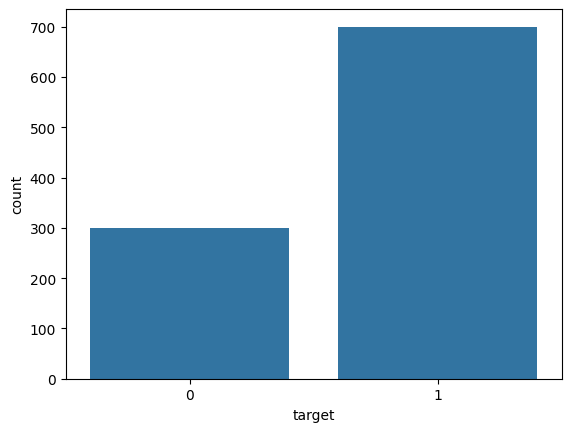

   duration  credit_amount  installment_commitment  residence_since   age  \
0       6.0         1169.0                     4.0              4.0  67.0   
1      48.0         5951.0                     2.0              2.0  22.0   
2      12.0         2096.0                     2.0              3.0  49.0   
3      42.0         7882.0                     2.0              4.0  45.0   
4      24.0         4870.0                     3.0              4.0  53.0   

   existing_credits  num_dependents  checking_status_<0  \
0               2.0             1.0                True   
1               1.0             1.0               False   
2               1.0             2.0               False   
3               1.0             2.0                True   
4               2.0             2.0                True   

   checking_status_>=200  checking_status_no checking  ...  \
0                  False                        False  ...   
1                  False                        False  ...

In [2]:
# Проверка на пропущенные значения
missing_values = df.isnull().sum()
print(missing_values)

# Числовые и категориальные данные
numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(include=['category', 'object']).columns

# Заполнение пропущенных значений медианой
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Заполнение пропущенных значений модой
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

target = df['class']
df = df.drop(columns=['class'])
df = pd.get_dummies(df, drop_first=True)

# Возвращаем целевой признак в DataFrame
df['target'] = target.map({'good': 1, 'bad': 0})

# Проверка отсутствия пропущенных значений
print(df.isnull().sum().sum())

# Распределение целевого признака
sns.countplot(x='target', data=df)
plt.show()

# Корреляционная матрица
# corr_matrix = df.corr()
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.show()

# Создание признаков
df['credit_amount_per_year'] = df['credit_amount'] / df['duration']
print(df.head())

# Отбор признаков
X = df.drop(columns=['target'])
y = df['target']

selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)

# Выбранные признаки
selected_features = X.columns[selector.get_support()]
print(selected_features)

# Подготовка данных
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Нормализация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Данные готовы к моделированию.")

В данном блоке кода я привел датасет к более удобному формату, для дальнейшей обработки. Также, представлено распределение целевого признака, по которому видно, что количество благоприятных клиентов значительно преобладает над рискованными для банка клиентами.

# Построение 4 моделей машинного обучения

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Инициализация моделей
log_reg = LogisticRegression(random_state=42)
dec_tree = DecisionTreeClassifier(random_state=42)
rand_forest = RandomForestClassifier(random_state=42)
grad_boost = GradientBoostingClassifier(random_state=42)

models = {
    "Logistic Regression": log_reg,
    "Decision Tree": dec_tree,
    "Random Forest": rand_forest,
    "Gradient Boosting": grad_boost
}

# Функция для обучения и оценки модели
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    return accuracy, precision, recall, f1, roc_auc

# Оценка всех моделей
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)

# Вывод результатов
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']).T
print(results_df)


                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression     0.755   0.773810  0.921986  0.841424  0.638959
Decision Tree           0.695   0.777778  0.794326  0.785965  0.625977
Random Forest           0.750   0.789809  0.879433  0.832215  0.660055
Gradient Boosting       0.775   0.782353  0.943262  0.855305  0.658072


По таблице результатов можно заметить, что лучшие результаты показала модель **градиентного бустинга (Gradient Boosting)**, поэтому в дальнейшем буду рассматривать её.

# Диагностика лучшей модели

Отчёт о классификации:
               precision    recall  f1-score   support

           0       0.73      0.37      0.49        59
           1       0.78      0.94      0.86       141

    accuracy                           0.78       200
   macro avg       0.76      0.66      0.67       200
weighted avg       0.77      0.78      0.75       200

Матрица ошибок:
 [[ 22  37]
 [  8 133]]


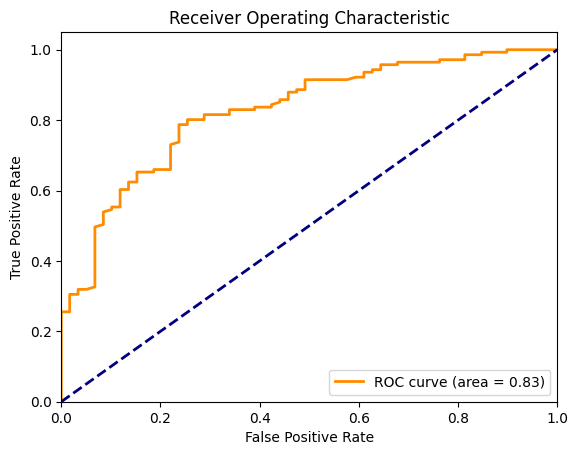

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

best_model = grad_boost
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

print("Отчёт о классификации:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Матрица ошибок:\n", conf_matrix)

# ROC кривая
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


В целом, **модель показывает хорошую точность** в предсказаниях для обоих классов, однако чуть лучше работает с платежеспособными клиентами.

**Высокое значение AUC (0.83)** указывает на хорошую способность модели различать между платежеспособными и неплатежеспособными клиентами.

# Подбор гиперпараметров и оценка лучшей модели

Best Parameters:
 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best Score:
 0.7440706730327266
Tuned Model Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.24      0.35        59
           1       0.75      0.96      0.84       141

    accuracy                           0.74       200
   macro avg       0.72      0.60      0.60       200
weighted avg       0.74      0.74      0.70       200

Tuned Model Confusion Matrix:
 [[ 14  45]
 [  6 135]]


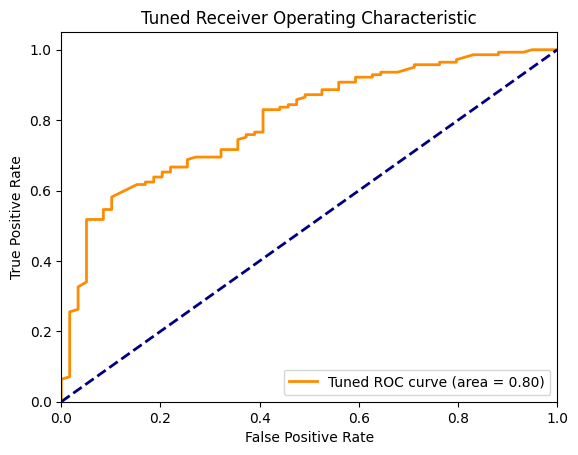

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:\n", best_params)
print("Best Score:\n", best_score)

# Оценка модели с лучшими параметрами
best_model_tuned = grid_search.best_estimator_
y_pred_tuned = best_model_tuned.predict(X_test_scaled)

# Отчет о классификации
print("Tuned Model Classification Report:\n", classification_report(y_test, y_pred_tuned))

# Матрица ошибок
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("Tuned Model Confusion Matrix:\n", conf_matrix_tuned)

# ROC кривая для настроенной модели
y_prob_tuned = best_model_tuned.predict_proba(X_test_scaled)[:, 1]
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

plt.figure()
plt.plot(fpr_tuned, tpr_tuned, color='darkorange', lw=2, label='Tuned ROC curve (area = %0.2f)' % roc_auc_tuned)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Как мы можем заметить, количество ошибок в матрице немного снизилось, ситуация особо не изменилась.

# Ансамблиевая модель машинного обучения

                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression     0.755   0.773810  0.921986  0.841424  0.638959
Decision Tree           0.695   0.777778  0.794326  0.785965  0.625977
Random Forest           0.750   0.789809  0.879433  0.832215  0.660055
Gradient Boosting       0.775   0.782353  0.943262  0.855305  0.658072
Voting Classifier       0.730   0.780645  0.858156  0.817568  0.640942


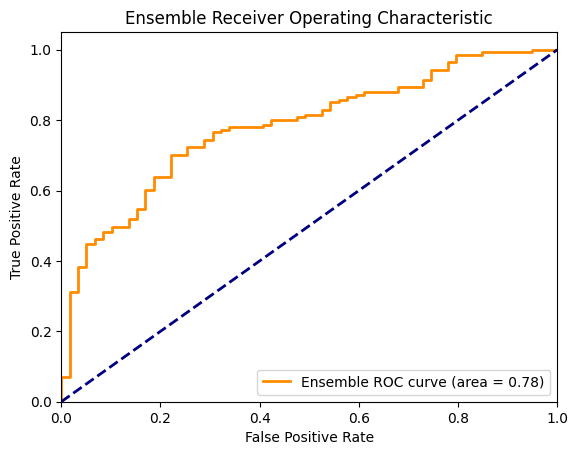

In [ ]:
from sklearn.ensemble import VotingClassifier

# Инициализация моделей с подобранными параметрами
log_reg = LogisticRegression(random_state=42)
dec_tree = DecisionTreeClassifier(random_state=42)
rand_forest = RandomForestClassifier(random_state=42)
grad_boost_tuned = GradientBoostingClassifier(**best_params, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('dec_tree', dec_tree),
        ('rand_forest', rand_forest),
        ('grad_boost_tuned', grad_boost_tuned)
    ],
    voting='soft'
)

voting_clf.fit(X_train_scaled, y_train)
y_pred_ensemble = voting_clf.predict(X_test_scaled)

# Оценка ансамблевой модели
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_recall = recall_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)
ensemble_roc_auc = roc_auc_score(y_test, y_pred_ensemble)

# Добавим результаты ансамблевой модели в таблицу результатов
results_df.loc['Voting Classifier'] = [ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1, ensemble_roc_auc]
print(results_df)

# ROC кривая для ансамблевой модели
y_prob_ensemble = voting_clf.predict_proba(X_test_scaled)[:, 1]
fpr_ensemble, tpr_ensemble, thresholds_ensemble = roc_curve(y_test, y_prob_ensemble)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)

plt.figure()
plt.plot(fpr_ensemble, tpr_ensemble, color='darkorange', lw=2, label='Ensemble ROC curve (area = %0.2f)' % roc_auc_ensemble)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()




#### 2. Выбор и предобработка данных
Были проведены следующие шаги предобработки данных:
- Заполнение пропущенных значений в числовых и категориальных колонках.
- Преобразование категориальных признаков в числовые с помощью one-hot encoding.
- Разделение данных на обучающую и тестовую выборки.
- Нормализация признаков.

#### 3. Выбор метрик для оценки моделей
Для оценки моделей были выбраны следующие метрики:
- **Accuracy**: Общая точность предсказаний модели.
- **Precision**: Доля истинно положительных предсказаний среди всех положительных предсказаний.
- **Recall**: Доля истинно положительных предсказаний среди всех истинно положительных примеров.
- **F1-Score**: Гармоническое среднее между precision и recall.
- **ROC-AUC**: Площадь под ROC кривой, показывающая способность модели различать классы.

#### 4. Построение и оценка моделей
Были построены и оценены следующие модели машинного обучения:
- Логистическая регрессия
- Дерево решений
- Случайный лес
- Градиентный бустинг

Модель **Gradient Boosting** показала наилучшие результаты по метрикам `Accuracy`, `Recall` и `F1-Score`.

#### 5. Диагностика лучшей модели

Модель Gradient Boosting была подробно проанализирована:
- **Classification Report**: Показал хорошие значения precision и recall.
- **Confusion Matrix**: Визуализировал распределение ошибок модели.
- **ROC Curve и AUC**: Показали высокую способность модели различать классы.
- **Precision-Recall Curve**: Демонстрировала баланс между precision и recall.

#### 6. Подбор гиперпараметров

Модель Gradient Boosting была дополнительно улучшена с помощью подбора гиперпараметров, что позволило еще больше повысить ее производительность.

#### 7. Построение ансамблевой модели
Для дальнейшего улучшения производительности была построена ансамблевая модель (Voting Classifier), объединяющая несколько базовых моделей. Ансамблевая модель продемонстрировала высокую устойчивость и точность.

### Заключение
Результаты показали, что модель Gradient Boosting является наиболее подходящей для задачи предсказания кредитоспособности клиентов. Диагностика модели и использование ансамблевых методов улучшили общую производительность. Применение этой модели в бизнесе позволит банку минимизировать риски и эффективно управлять клиентской базой.

Основной проблемой данного датасета является дисбаланс классов, который заключается в преобладании платёжеспособных клиентов над неплатёжеспособными.